## Asycronous clients

This example illustrates how one can work with asyncronous clients using FEDn.

### ML model

We will train a Multilayer Perceptron (MLPClassifier) from sklearn with default parameters. 

In [5]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

For the centralized model we generate synthetic data for a classification problem based on 4 features. 

In [ ]:
# We generate a simulated dataset for classification
X, y = make_classification(n_samples=10000, n_features=4, random_state=42)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

The model is defined in the FEDn entrypoint file, we import it here and fit it to the dataset.

In [4]:
from client.entrypoint import compile_model

clf = compile_model(max_iter=300)
clf.fit(X_train, y_train)

print("Training accuracy: ", accuracy_score(y_train, clf.predict(X_train)))
print("Test accuracy: ", accuracy_score(y_test, clf.predict(X_test)))

Training accuracy:  0.94
Test accuracy:  0.9366666666666666


In [7]:
from fedn import APIClient
from fedn.network.clients.client import Client
import uuid
import json
import matplotlib.pyplot as plt
import numpy as np
import collections
import copy

We make a client connection to the FEDn API service. Here we assume that FEDn is deployed locally in pseudo-distributed mode with default ports.

In [9]:
DISCOVER_HOST = '127.0.0.1'
DISCOVER_PORT = 8092
client = APIClient(DISCOVER_HOST, DISCOVER_PORT)

Next, we retrive all model validations from all clients, extract the training accuracy metric, and compute its mean value accross all clients

In [28]:
models = client.list_models(session_id = "7aa63e7c-d659-4ac2-8d21-ce90fcb3a488")

validations = []
acc = collections.OrderedDict()
for model in models["result"]:
    model_id = model["model"]
    validations = client.list_validations(modelId=model_id)

    for _ , validation in validations.items(): 
        metrics = json.loads(validation['data'])
        try:
            acc[model_id].append(metrics['accuracy_score'])
        except KeyError: 
            acc[model_id] = [metrics['accuracy_score']]
            
mean_acc_fedavg = []
for model, data in acc.items():
    mean_acc_fedavg.append(np.mean(data))
mean_acc_fedavg.reverse()

Plot the result.

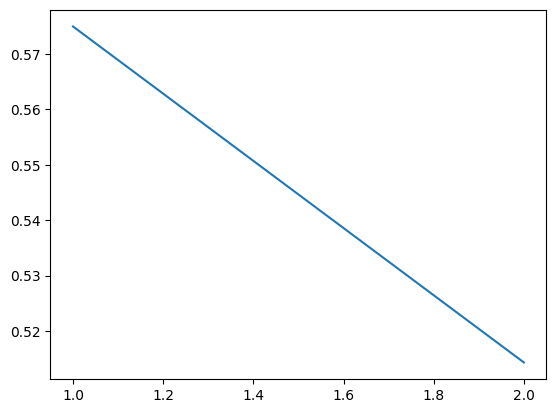

In [29]:
x = range(1,len(mean_acc_fedavg)+1)
plt.plot(x, mean_acc_fedavg)